In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import gc
import os
import sys
%matplotlib inline

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
cab_data = pd.read_csv("cab_rides.csv")
weather_data = pd.read_csv("weather.csv")

In [7]:
cab_data

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL
...,...,...,...,...,...,...,...,...,...,...
24621,2.46,Uber,1543477978043,Beacon Hill,Fenway,33.5,1.0,442b63af-2b6c-445e-a242-89ae2432012c,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV
24622,2.46,Uber,1545143711880,Beacon Hill,Fenway,NaN,1.0,6031d71e-f2bb-4d65-adb9-a3868c7aa588,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
24623,2.46,Uber,1543793277652,Beacon Hill,Fenway,8.5,1.0,62a141e6-c1e5-4c4a-9177-8365f2b89f76,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool
24624,2.46,Uber,1545067212429,Beacon Hill,Fenway,11.0,1.0,8e92ef47-5e15-48ed-82c4-d019ecb55974,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV


In [8]:
weather_data

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.00,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.00,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.00,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.00,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.00,1012.14,0.1786,1545003901,0.75,11.49
...,...,...,...,...,...,...,...,...
6271,44.72,North Station,0.89,1000.69,NaN,1543819974,0.96,1.52
6272,44.85,Northeastern University,0.88,1000.71,NaN,1543819974,0.96,1.54
6273,44.82,South Station,0.89,1000.70,NaN,1543819974,0.96,1.54
6274,44.78,Theatre District,0.89,1000.70,NaN,1543819974,0.96,1.54


In [9]:
import datetime
cab_data['datetime']= pd.to_datetime(cab_data['time_stamp'])
cab_data
weather_data['date_time'] = pd.to_datetime(weather_data['time_stamp'])

In [10]:
cab_data.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime'],
      dtype='object')

In [11]:
weather_data.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'time_stamp',
       'humidity', 'wind', 'date_time'],
      dtype='object')

In [12]:
cab_data.shape

(24626, 11)

In [13]:
weather_data.shape

(6276, 9)

In [14]:
cab_data.describe()

,distance,time_stamp,price,surge_multiplier
count,24626.000000,2.462600e+04,22689.000000,24626.000000
mean,2.152670,1.544032e+12,16.447419,1.015096
std,1.120872,6.877608e+08,9.243306,0.096001
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.250000,1.543439e+12,9.000000,1.000000
50%,2.100000,1.543724e+12,13.500000,1.000000
75%,2.860000,1.544816e+12,22.500000,1.000000
max,7.460000,1.545161e+12,80.000000,2.500000


In [15]:
weather_data.describe()

,temp,clouds,pressure,rain,time_stamp,humidity,wind
count,6276.000000,6276.000000,6276.000000,894.000000,6.276000e+03,6276.000000,6276.000000
mean,39.090475,0.677777,1008.445209,0.057652,1.543857e+09,0.763985,6.802812
std,6.022055,0.314284,12.870775,0.100758,6.659340e+05,0.127340,3.633466
min,19.620000,0.000000,988.250000,0.000200,1.543204e+09,0.450000,0.290000
25%,36.077500,0.440000,997.747500,0.004900,1.543387e+09,0.670000,3.517500
50%,40.130000,0.780000,1007.660000,0.014850,1.543514e+09,0.760000,6.570000
75%,42.832500,0.970000,1018.480000,0.060925,1.544691e+09,0.890000,9.920000
max,55.410000,1.000000,1035.120000,0.780700,1.545159e+09,0.990000,18.180000


In [16]:
a=pd.concat([cab_data,weather_data])

In [17]:
a['day']=a.date_time.dt.day
a['hour']=a.date_time.dt.hour

In [18]:
a.fillna(0,inplace=True)

In [19]:
a.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind',
       'date_time', 'day', 'hour'],
      dtype='object')

In [20]:
a.groupby('cab_type').count()

,distance,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,datetime,temp,location,clouds,pressure,rain,humidity,wind,date_time,day,hour
cab_type,,,,,,,,,,,,,,,,,,,,
0,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276,6276
Lyft,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099,11099
Uber,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527,13527


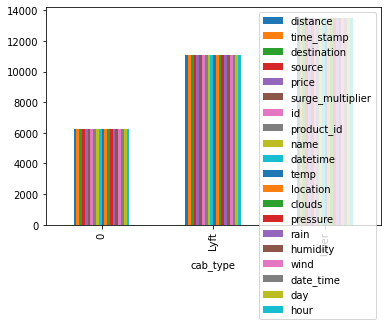

In [21]:
a.groupby('cab_type').count().plot.bar()

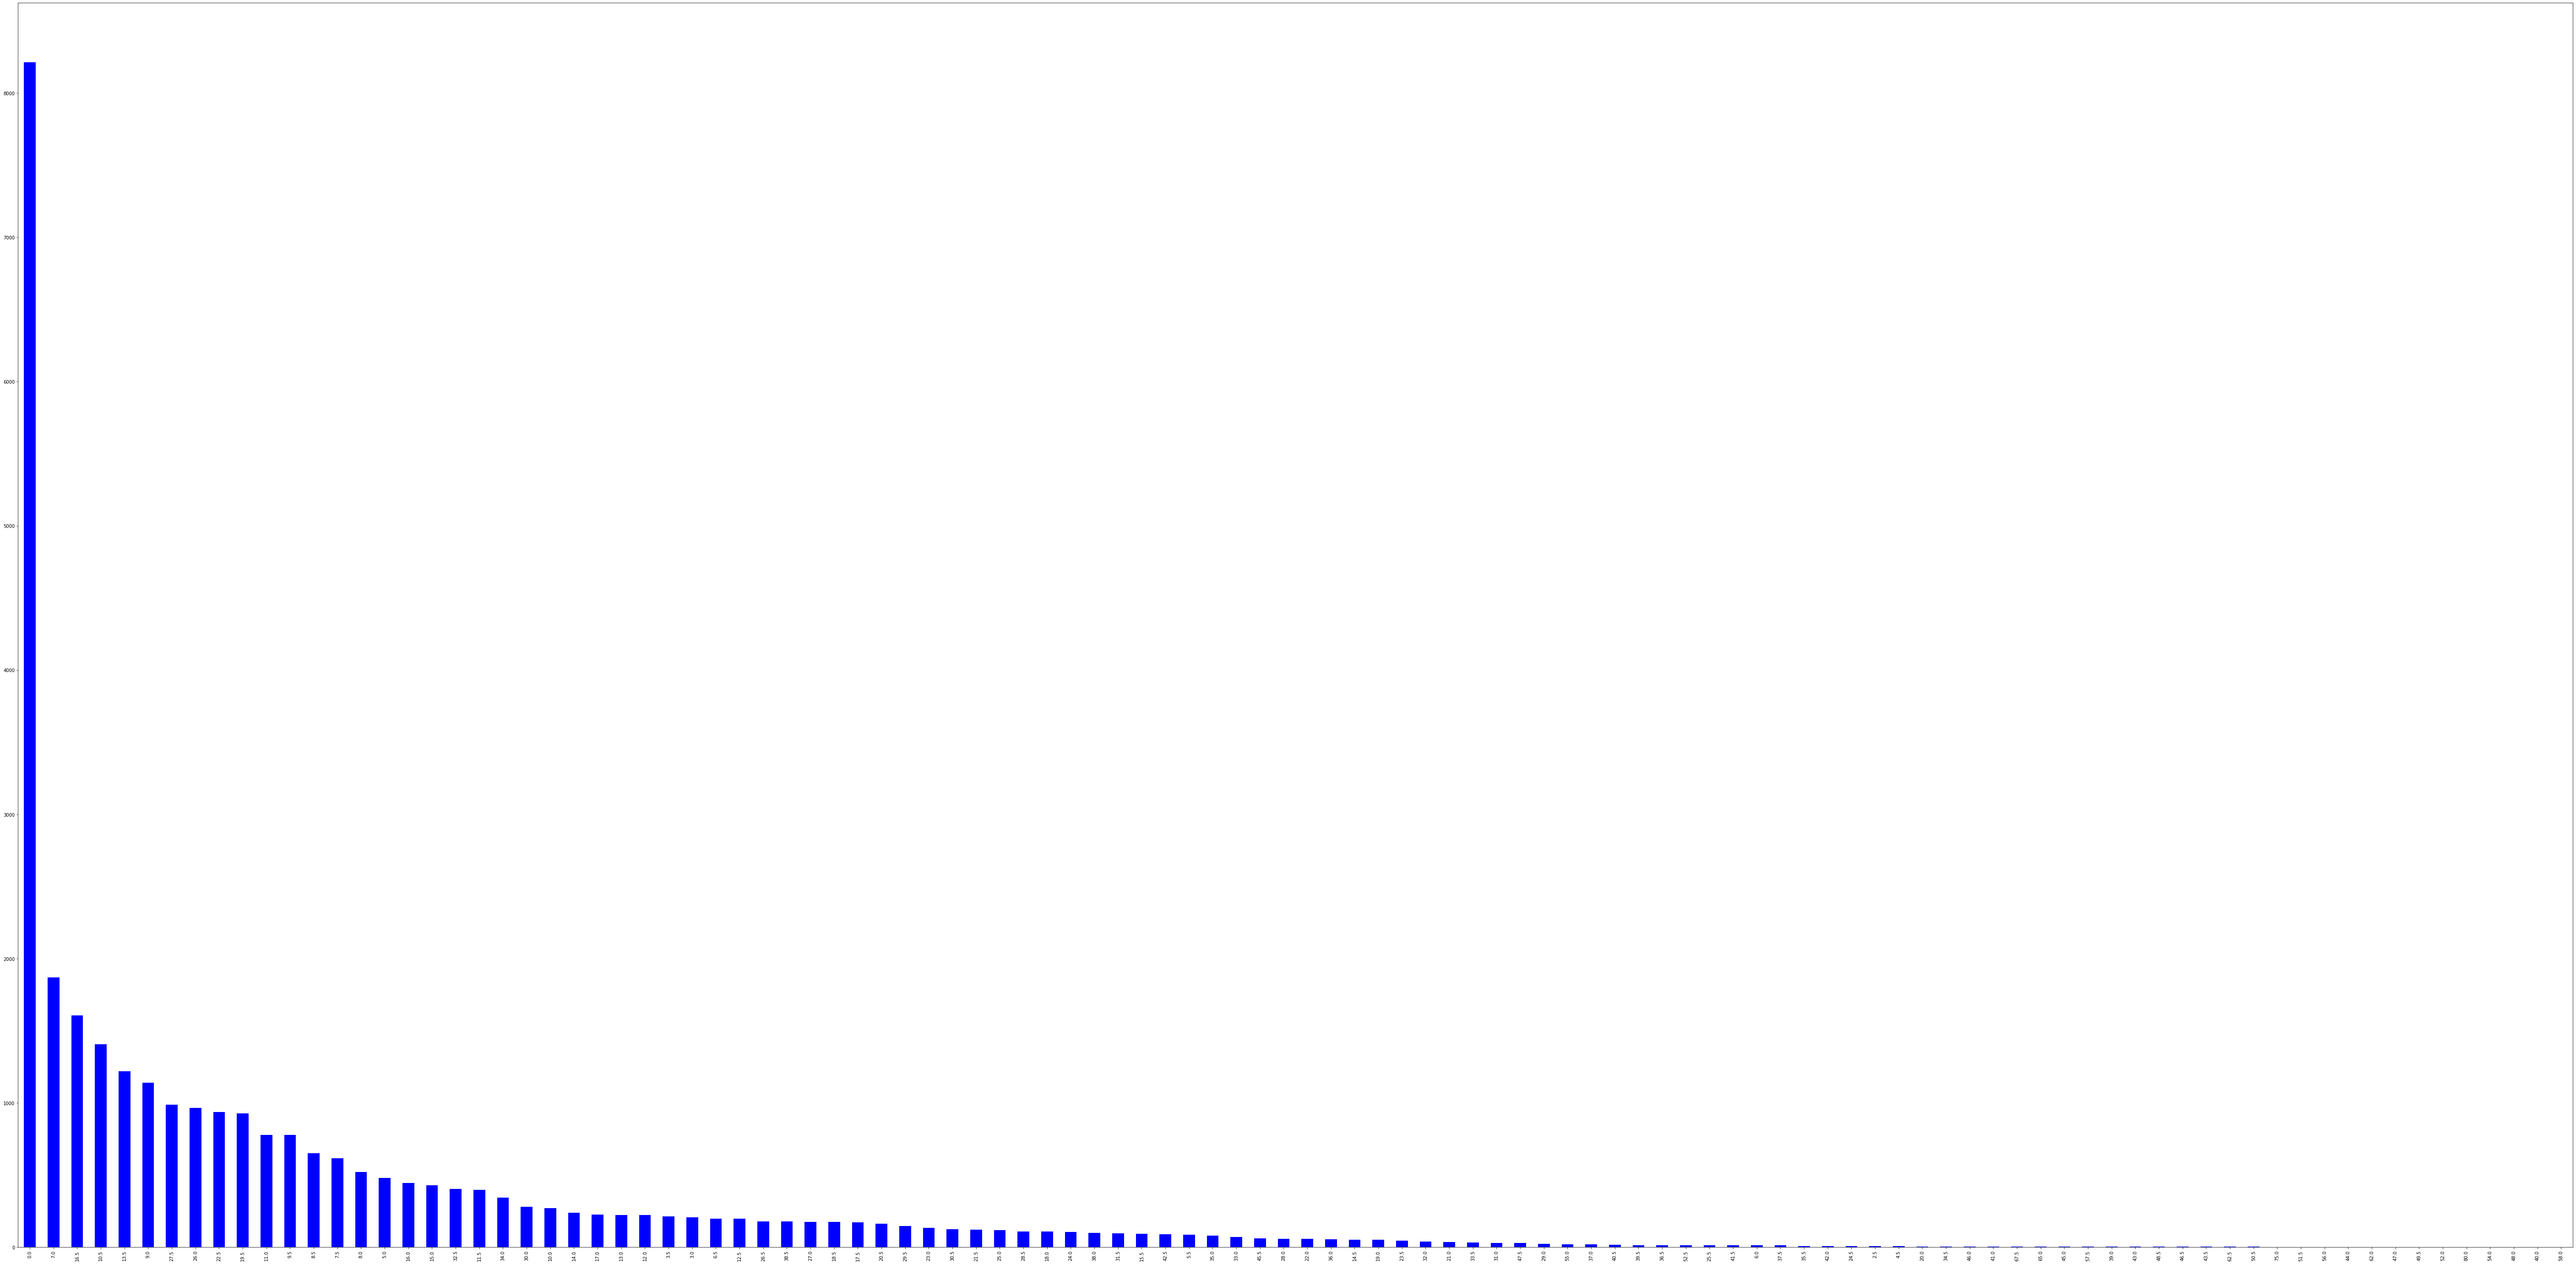

In [22]:
a['price'].value_counts().plot(kind='bar',figsize=(100,50),color='blue')


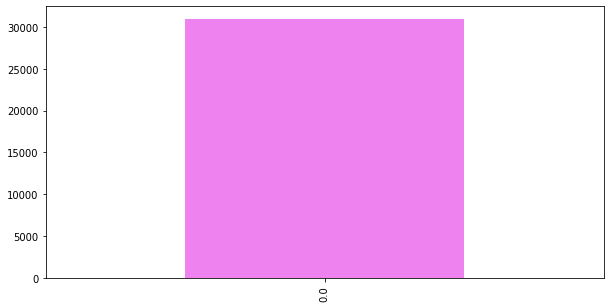

In [23]:
a['hour'].value_counts().plot(kind='bar',figsize=(10,5),color='violet')

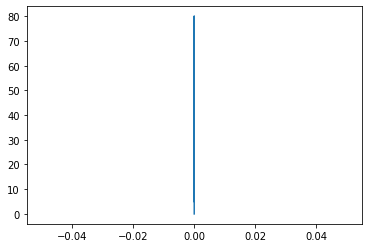

In [24]:
import matplotlib.pyplot as plt
x=a['hour']
y=a['price']
plt.plot(x,y)
plt.show()


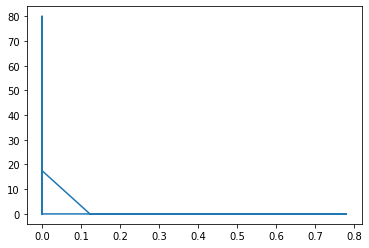

In [25]:
x=a['rain']
y=a['price']
plt.plot(x,y)
plt.show()

In [26]:
a.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name', 'datetime', 'temp',
       'location', 'clouds', 'pressure', 'rain', 'humidity', 'wind',
       'date_time', 'day', 'hour'],
      dtype='object')

In [27]:
x1=a[['distance', 'temp','clouds', 'pressure', 'humidity','wind','rain','day','hour','surge_multiplier','clouds']]
y1=a['price']

In [28]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
x_train, y_train, x_test, y_test = train_test_split(x1, y1, test_size = 0.25, random_state = 42)

In [29]:
linear=LinearRegression()
linear.fit(x_train,x_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
predictions=linear.predict(y_train)

In [31]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
df

,Actual,Predicted
22404,0.0,12.731283
22096,26.0,13.171834
7204,15.0,16.670330
7949,10.5,10.969077
17957,10.5,16.618500
...,...,...
13416,7.0,12.498050
19461,31.5,17.214540
15865,27.5,11.357799
13344,0.0,16.152034


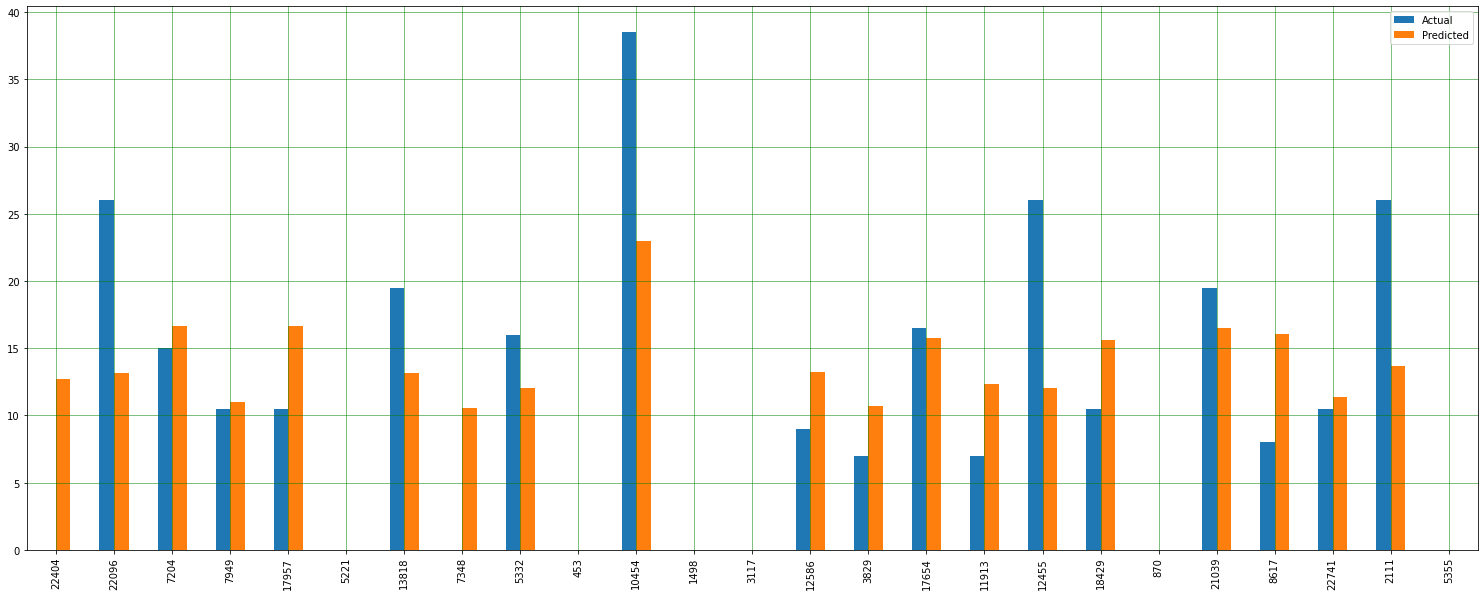

In [32]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(26,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()